In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [2]:
np.random.seed(42)
set_config(display='diagram')

In [3]:
# additional setup of the tools
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="whitegrid")

In [4]:
trainDf = pd.read_csv("data/train.csv")
testDf = pd.read_csv("data/test.csv")

In [5]:
# Remove outliers
trainDf.drop(trainDf[(trainDf["GrLivArea"] > 4000) & (trainDf["SalePrice"] < 700000)].index);

In [6]:
baselineFeatures = ['GrLivArea', 'OverallQual', 'GarageCars', 'OverallCond', 'Neighborhood'] # 'Neighborhood', 'MSZoning'

X = trainDf[baselineFeatures]
Y = trainDf['SalePrice']

X

,GrLivArea,OverallQual,GarageCars,OverallCond,Neighborhood
0,1710,7,2,5,CollgCr
1,1262,6,2,8,Veenker
2,1786,7,2,5,CollgCr
3,1717,7,3,5,Crawfor
4,2198,8,3,5,NoRidge
...,...,...,...,...,...
1455,1647,6,2,5,Gilbert
1456,2073,6,2,6,NWAmes
1457,2340,7,1,9,Crawfor
1458,1078,5,1,6,NAmes


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [21]:
# Build feature transformer

featureTransformer = ColumnTransformer([
        ('living_area_std_scale', StandardScaler(), ['GrLivArea']),
        ('neighborhood_onehot', OneHotEncoder(), ['Neighborhood']),
    ],
    remainder='passthrough'
)

featureTransformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('living_area_std_scale', StandardScaler(),
                                 ['GrLivArea']),
                                ('neighborhood_onehot', OneHotEncoder(),
                                 ['Neighborhood'])])

In [23]:
# View of transformed training set

featureTransformer.fit(X_train)
featureTransformer.named_transformers_['neighborhood_onehot'].get_feature_names()

array(['x0_Blmngtn', 'x0_Blueste', 'x0_BrDale', 'x0_BrkSide',
       'x0_ClearCr', 'x0_CollgCr', 'x0_Crawfor', 'x0_Edwards',
       'x0_Gilbert', 'x0_IDOTRR', 'x0_MeadowV', 'x0_Mitchel', 'x0_NAmes',
       'x0_NPkVill', 'x0_NWAmes', 'x0_NoRidge', 'x0_NridgHt',
       'x0_OldTown', 'x0_SWISU', 'x0_Sawyer', 'x0_SawyerW', 'x0_Somerst',
       'x0_StoneBr', 'x0_Timber', 'x0_Veenker'], dtype=object)

In [10]:
# Initialize Regression Model
baselineModel = LinearRegression()

In [11]:
regressionPipeline = Pipeline([
    ("preprocessing", featureTransformer),
    ("regression", baselineModel)
])

In [12]:
regressionPipeline.fit(X_train, y_train)

y_train_predicted = regressionPipeline.predict(X_train)
y_test_predicted = regressionPipeline.predict(X_test)

In [13]:
## Metrics from Test Data
print('[Train] Mean Squared Error: %.2f' % mean_squared_error(y_train, y_train_predicted))
# The coefficient of determination: 1 is perfect prediction
print('[Train] Coefficient of Determination: %.2f' % r2_score(y_train, y_train_predicted))

[Train] Mean Squared Error: 1269550833.66
[Train] Coefficient of Determination: 0.79


In [14]:
## Metrics from Test Data
print('[Test] Mean Squared Error: %.2f' % mean_squared_error(y_test, y_test_predicted))
# The coefficient of determination: 1 is perfect prediction
print('[Test] Coefficient of Determination: %.2f' % r2_score(y_test, y_test_predicted))

[Test] Mean Squared Error: 1232112471.74
[Test] Coefficient of Determination: 0.82


In [15]:
def plot_regression_results(ax, y_true, y_pred, title):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    
    ax.set_title(title)

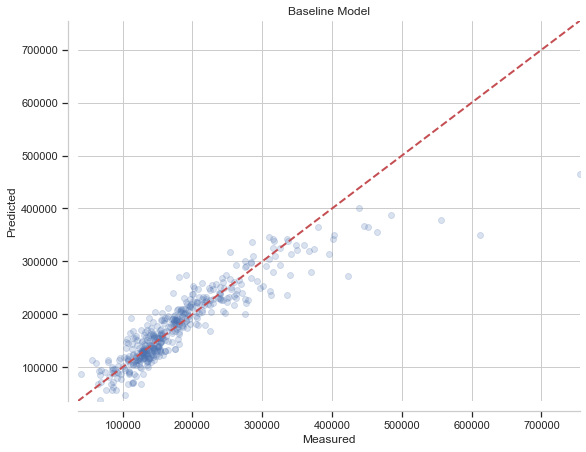

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

plot_regression_results(
    ax, 
    y_true=y_test, 
    y_pred=y_test_predicted, 
    title="Baseline Model"
)